In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv("../data/survey_results.csv")

# View dataset
df.head(5)

,respondent_id,age,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range
0,R00001,30,M,Urban,Working Professional,<10L,3-4 times,Newcomer,Medium (500 ml),0 to 1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150
1,R00002,46,F,Metro,Working Professional,> 35L,5-7 times,Established,Medium (500 ml),2 to 4,Quality,Exotic,Retail Store,Premium,Medium (Moderately health-conscious),Social (eg. Parties),200-250
2,R00003,41,F,Rural,Working Professional,> 35L,3-4 times,Newcomer,Medium (500 ml),2 to 4,Availability,Traditional,Retail Store,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",200-250
3,R00004,33,F,Urban,Working Professional,16L - 25L,5-7 times,Newcomer,Medium (500 ml),0 to 1,Brand Reputation,Exotic,Online,Eco-Friendly,Low (Not very concerned),"Active (eg. Sports, gym)",150-200
4,R00005,23,M,Metro,Student,None,3-4 times,Established,Medium (500 ml),0 to 1,Availability,Traditional,Online,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",50-100


In [3]:
df.shape

(30010, 17)

# Data Cleaning

#### 1: Remove Duplicates
Investigate if the dataset contains duplicate entries. Consider which columns could help identify duplicates. Think about how duplicate records might affect the outcome of the model and remove them accordingly.

In [4]:
print(f"Original shape: {df.shape}")
duplicate_count = df.duplicated().sum()
print(f"Duplicates found: {duplicate_count}")

Original shape: (30010, 17)
Duplicates found: 10


In [5]:
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")
else:
    print("No duplicates found.")

Duplicates removed.


#### 2: Outlier Detection in 'Age' Column
Explore the 'age column to spot potential outliers. You can use statistical methods or visualizations (e.g., box plots) to help identify these. Reflect on why it's important to handle these outliers. Based on your findings, decide whether to keep, adjust, or remove them.

In [6]:
# Explore 'age' column
print("\nAge statistics before cleaning:")
print(df['age'].describe())


Age statistics before cleaning:
count    30000.000000
mean        33.048167
std         13.438904
min         18.000000
25%         23.000000
50%         31.000000
75%         40.000000
max        604.000000
Name: age, dtype: float64


Plot saved to images/age_boxplot.png


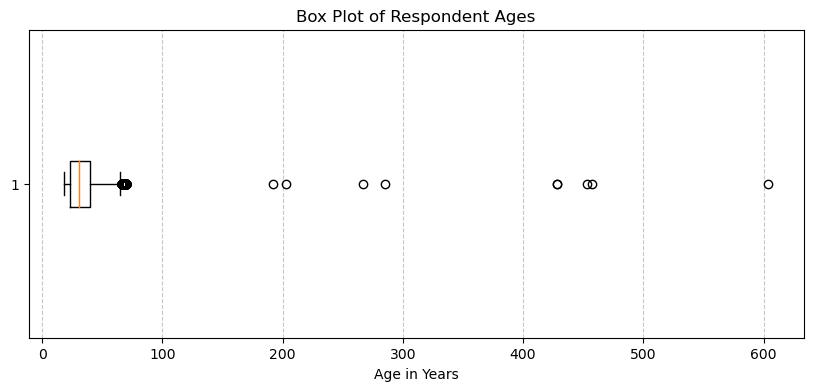

In [7]:
# Create the Box Plot
plt.figure(figsize=(10, 4))  # Sets the size of the plot
plt.boxplot(df['age'], vert=False)  # vert=False makes it horizontal
plt.title('Box Plot of Respondent Ages')
plt.xlabel('Age in Years')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Save the plot
plt.savefig('../outputs/figures/age_boxplot.png', bbox_inches='tight')
print("Plot saved to images/age_boxplot.png")

# Show the plot
plt.show()

In [8]:
# We see max age is 604. Let's filter for realistic ages (e.g., 18 to 100).
valid_age_mask = (df['age'] >= 18) & (df['age'] <= 100)
outliers_removed = len(df) - valid_age_mask.sum()

df = df[valid_age_mask]

print(f"Removed {outliers_removed} rows with unrealistic ages.")
print("New Age Stats:")
print(df['age'].describe())

Removed 9 rows with unrealistic ages.
New Age Stats:
count    29991.000000
mean        32.947484
std         11.906077
min         18.000000
25%         23.000000
50%         31.000000
75%         40.000000
max         70.000000
Name: age, dtype: float64


##### 3. Handling Missing Data:
- For the 'income_levels column, missing values can be problematic. What would be a reasonable way to replace them? (Hint: Consider using "Not Reported" for missing income levels)

- For the consume_frequency(weekly)' and purchase_channel columns, think about the best way to fill missing values. Could the most common (mode) values be an appropriate replacement? Investigate the distributions before making a decision.

In [9]:
# Income Levels: Replace missing with "Not Reported"
missing_income = df['income_levels'].isnull().sum()
if missing_income > 0:
    df['income_levels'].fillna('Not Reported', inplace=True)
    print(f"Filled {missing_income} missing 'income_levels' with 'Not Reported'.")

In [10]:
# Consumption Frequency & Purchase Channel: Replace with Mode
# 'mode()[0]' gets the most frequent value
for col in ['consume_frequency(weekly)', 'purchase_channel']:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled {missing_count} missing '{col}' with mode: '{mode_value}'.")

Filled 8 missing 'consume_frequency(weekly)' with mode: '3-4 times'.
Filled 10 missing 'purchase_channel' with mode: 'Online'.


##### 4. Correcting Spelling Mistakes in Categorical Data:

• Review the entries in the 'zone' and 'current_brand' columns. Are there any inconsistencies in spelling or formatting? How could you identify and fix these issues to ensure uniform categories?

In [11]:
# Print unique values to spot the errors
print("Unique Zones found:", df['zone'].unique())
print("Unique Brands found:", df['current_brand'].unique())

Unique Zones found: ['Urban' 'Metro' 'Rural' 'Semi-Urban' 'Metor' 'urbna']
Unique Brands found: ['Newcomer' 'Established' 'newcomer' 'Establishd']


In [12]:
count_metor = df[df['zone'] == 'Metor'].shape[0]

print(f"Rows with misspelling 'Metor': {count_metor}")

Rows with misspelling 'Metor': 4


In [13]:
corrections = {
    # Zone Corrections
    'Metor': 'Metro',
    'urbna': 'Urban',
    
    # Brand Corrections 
    'newcomer ': 'Newcomer', 
    'Establishd': 'Established',
}

# Apply the corrections
df['zone'] = df['zone'].replace(corrections)
df['current_brand'] = df['current_brand'].replace(corrections)

In [14]:
# Final check
print("Corrections applied.")
print("Unique Zones After Cleaning:", df['zone'].unique())

Corrections applied.
Unique Zones After Cleaning: ['Urban' 'Metro' 'Rural' 'Semi-Urban']


In [15]:
# Save cleaned data
df.to_csv('../data/survey_results_cleaned.csv', index=False)
print("\nData cleaning complete. Saved as 'survey_results_cleaned.csv'.")


Data cleaning complete. Saved as 'survey_results_cleaned.csv'.


# Feature Engineering

In [16]:
# Load the cleaned dataset
df = pd.read_csv('../data/survey_results_cleaned.csv')

# View dataset
df.head(5)

,respondent_id,age,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range
0,R00001,30,M,Urban,Working Professional,<10L,3-4 times,Newcomer,Medium (500 ml),0 to 1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150
1,R00002,46,F,Metro,Working Professional,> 35L,5-7 times,Established,Medium (500 ml),2 to 4,Quality,Exotic,Retail Store,Premium,Medium (Moderately health-conscious),Social (eg. Parties),200-250
2,R00003,41,F,Rural,Working Professional,> 35L,3-4 times,Newcomer,Medium (500 ml),2 to 4,Availability,Traditional,Retail Store,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",200-250
3,R00004,33,F,Urban,Working Professional,16L - 25L,5-7 times,Newcomer,Medium (500 ml),0 to 1,Brand Reputation,Exotic,Online,Eco-Friendly,Low (Not very concerned),"Active (eg. Sports, gym)",150-200
4,R00005,23,M,Metro,Student,None,3-4 times,Established,Medium (500 ml),0 to 1,Availability,Traditional,Online,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",50-100


##### 1. Categorize Age into Age Groups
**Objective:** Create a new column `age_group` by categorizing the existing `age` column into specific age ranges.
- Categorize ages into the following groups:
    - 18-25
    - 26-35
    - 36-45
    - 46-55
    - 56-70
    - 70+
- Ensure that each age in the dataset is mapped to one of these age groups.
- After that, remove the original `age` column from the dataset.

In [17]:
# Define the bins and labels
# Bins logic: (17, 25] covers 18-25, (25, 35] covers 26-35, etc.
bins = [17, 25, 35, 45, 55, 70, 150]
labels = ['18-25', '26-35', '36-45', '46-55', '56-70', '70+']

In [18]:
# Create the new column
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

In [19]:
# Remove the original 'age' column as requested
df.drop(columns=['age'], inplace=True)
print("Created 'age_group' and dropped 'age'.")
print(df['age_group'].value_counts().sort_index())

Created 'age_group' and dropped 'age'.
18-25    10468
26-35     9093
36-45     5972
46-55     2966
56-70     1492
70+          0
Name: age_group, dtype: int64


##### 2. Create `cf_ab_score` (Consume Frequency and Awareness Brand Score)
**Objective:** Create a new column `cf_ab_score` by combining the information from `consume_frequency(weekly)` and `awareness_of_other_brands` columns.
- Use the following mappings for consume_frequency(weekly):
    - "0-2 times" → 1
    - "3-4 times" → 2
    - "5-7 times" → 3
- Use the following mappings for awareness_of_other_brands:
    - "0 to 1" → 1
    - "2 to 4" → 2
    - "above 4" → 3
- Calculate cf_ab_score using the following formula:
    `cf_ab_score = frequency_score / (awareness_score + frequency_score)
- Round the result to two decimal places.

In [20]:
# Define mappings
freq_map = {
    "0-2 times": 1,
    "3-4 times": 2,
    "5-7 times": 3
}

aware_map = {
    "0 to 1": 1,
    "2 to 4": 2,
    "above 4": 3
}

In [21]:
# Apply mappings to create temporary numeric series
freq_score = df['consume_frequency(weekly)'].map(freq_map)
aware_score = df['awareness_of_other_brands'].map(aware_map)

In [22]:
# Handle cases where map might result in NaN or Null
freq_score = freq_score.fillna(0)
aware_score = aware_score.fillna(0)

In [23]:
# Calculate the score
# Formula: frequency_score / (awareness_score + frequency_score)

denominator = aware_score + freq_score
df['cf_ab_score'] = freq_score / denominator

In [24]:
# Replace inf/nan with 0
df['cf_ab_score'] = df['cf_ab_score'].fillna(0.0)

In [25]:
# Round to two decimal places
df['cf_ab_score'] = df['cf_ab_score'].round(2)

print("Created 'cf_ab_score'. Sample values:")
print(df[['consume_frequency(weekly)', 'awareness_of_other_brands', 'cf_ab_score']].head())

Created 'cf_ab_score'. Sample values:
  consume_frequency(weekly) awareness_of_other_brands  cf_ab_score
0                 3-4 times                    0 to 1         0.67
1                 5-7 times                    2 to 4         0.60
2                 3-4 times                    2 to 4         0.50
3                 5-7 times                    0 to 1         0.75
4                 3-4 times                    0 to 1         0.67


##### 3: Create Zone Affluence Score (ZAS)
**Objective:** Calculate the `zas_score` using a combination of the `zone` and `income_levels` columns.
- Use the following mappings for the zone column:
    - "Urban" → 3
    - "Metro" → 4
    - "Rural" → 1
    - "Semi-Urban" → 2
- Use the following mappings for the income_levels column:
    - "<10L" → 1
    - "10L - 15L" → 2
    - "16L - 25L" → 3
    - "26L - 35L" → 4
    - "> 35L" → 5
    - "Not Reported" → 0
- Calculate the zas_score using the following formula:
  `zas_score = zone_score * income_score`

In [26]:
df['income_levels'].unique()

array(['<10L', '> 35L', '16L - 25L', 'None', '10L - 15L', '26L - 35L'],
      dtype=object)

In [27]:
zone_map = {
    "Rural": 1,
    "Semi-Urban": 2,
    "Urban": 3,
    "Metro": 4
}

income_map = {
    "Not Reported": 0,
    "<10L": 1,
    "10L - 15L": 2,
    "16L - 25L": 3,
    "26L - 35L": 4,
    "> 35L": 5
}

In [28]:
# Create numeric columns for calculation
z_score = df['zone'].map(zone_map).fillna(0)
i_score = df['income_levels'].map(income_map).fillna(0)

In [29]:
# Calculate ZAS
df['zas_score'] = z_score * i_score

print("Created 'zas_score'. Sample values:")
print(df[['zone', 'income_levels', 'zas_score']].head())

Created 'zas_score'. Sample values:
    zone income_levels  zas_score
0  Urban          <10L        3.0
1  Metro         > 35L       20.0
2  Rural         > 35L        5.0
3  Urban     16L - 25L        9.0
4  Metro          None        0.0


In [30]:
# Get the count of unique values
num_unique = df['zas_score'].nunique()

# Get the list of actual unique values (sorted for easier reading)
unique_vals = sorted(df['zas_score'].unique())

print(f"Number of unique values: {num_unique}")
print(f"Values: {unique_vals}")

Number of unique values: 14
Values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 12.0, 15.0, 16.0, 20.0]


##### 4: Brand Switching Indicator (BSI)
**Objective:** Create a binary indicator column `bsi` that identifies if a respondent is likely to switch brands.
- Check if the respondent’s current_brand is not "Established".
- Also check if the reasons_for_choosing_brands are either "Price" or "Quality".
- If both conditions are true, assign a value of 1 to indicate potential for brand switching. Otherwise, assign 0.

In [31]:
# Check if Current brand is NOT "Established"
cond1 = df['current_brand'] != 'Established'

# Check if Reason is "Price" OR "Quality"
cond2 = df['reasons_for_choosing_brands'].isin(['Price', 'Quality'])

# Combine conditions (Both must be True)
df['bsi'] = (cond1 & cond2).astype(int)

print("Created 'bsi' column.")
print("BSI Distribution:")
print(df['bsi'].value_counts())

Created 'bsi' column.
BSI Distribution:
0    20816
1     9175
Name: bsi, dtype: int64


In [32]:
# save final dataset
output_filename = '../data/survey_results_featured.csv'
df.to_csv(output_filename, index=False)
print(f"\nFeature Engineering Complete! Saved to '{output_filename}'.")


Feature Engineering Complete! Saved to '../data/survey_results_featured.csv'.


##### Final Cleaning Step:
**Removing Logical Outliers:**
- When reviewing the occupation data, we found logical inconsistencies. For instance, there are students listed in the `56-70` age group, which seems like an incorrect entry. We need to remove such records where the data doesn't make sense logically.

In [33]:
df = pd.read_csv('../data/survey_results_featured.csv')

# View dataset
df.head(5)

,respondent_id,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range,age_group,cf_ab_score,zas_score,bsi
0,R00001,M,Urban,Working Professional,<10L,3-4 times,Newcomer,Medium (500 ml),0 to 1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150,26-35,0.67,3.0,1
1,R00002,F,Metro,Working Professional,> 35L,5-7 times,Established,Medium (500 ml),2 to 4,Quality,Exotic,Retail Store,Premium,Medium (Moderately health-conscious),Social (eg. Parties),200-250,46-55,0.60,20.0,0
2,R00003,F,Rural,Working Professional,> 35L,3-4 times,Newcomer,Medium (500 ml),2 to 4,Availability,Traditional,Retail Store,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",200-250,36-45,0.50,5.0,0
3,R00004,F,Urban,Working Professional,16L - 25L,5-7 times,Newcomer,Medium (500 ml),0 to 1,Brand Reputation,Exotic,Online,Eco-Friendly,Low (Not very concerned),"Active (eg. Sports, gym)",150-200,26-35,0.75,9.0,0
4,R00005,M,Metro,Student,None,3-4 times,Established,Medium (500 ml),0 to 1,Availability,Traditional,Online,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",50-100,18-25,0.67,0.0,0


In [34]:
# Check initial count
initial_count = len(df)
print(f"Total records before cleaning: {initial_count}")

Total records before cleaning: 29991


In [35]:
# Define the condition for the logical error
# Condition: Respondent is a "Student" AND is in age group "56-70" OR "70+"
# (You can add more rules here if needed, e.g., 'Retired' people in '18-25')
outlier_condition = (
    (df['occupation'] == 'Student') & 
    (df['age_group'].isin(['56-70', '70+']))
)

In [36]:
# Identify how many rows will be dropped
outliers_count = outlier_condition.sum()
print(f"identified {outliers_count} logical outliers (Students aged 56+).")

identified 35 logical outliers (Students aged 56+).


In [37]:
# Remove the outliers
# We keep rows that do NOT (~) meet the outlier condition
df_final = df[~outlier_condition]

In [38]:
# Verify the removal
final_count = len(df_final)
print(f"Total records after cleaning: {final_count}")

if initial_count - final_count == outliers_count:
    print("Verification Successful: Correct number of rows removed.")
else:
    print("Verification Warning: Discrepancy in row counts.")

Total records after cleaning: 29956
Verification Successful: Correct number of rows removed.


In [39]:
# Check if Current brand is NOT "Established"
cond1 = df_final['current_brand'] != 'Established'

# Check if Reason is "Price" OR "Quality"
cond2 = df_final['reasons_for_choosing_brands'].isin(['Price', 'Quality'])

# Combine conditions (Both must be True)
df_final['bsi'] = (cond1 & cond2).astype(int)

print("Created 'bsi' column.")
print("BSI Distribution:")
print(df_final['bsi'].value_counts())

Created 'bsi' column.
BSI Distribution:
0    20796
1     9160
Name: bsi, dtype: int64


In [40]:
# Save the final dataset
output_filename = '../data/survey_results_final.csv'
df_final.to_csv(output_filename, index=False)
print(f"\nFinal cleaning complete! Gold dataset saved to '{output_filename}'.")


Final cleaning complete! Gold dataset saved to '../data/survey_results_final.csv'.


# Predictive Modeling

In [41]:
# Load the dataset
df = pd.read_csv('../data/survey_results_final.csv')

# View dataset
df.head(5)

,respondent_id,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range,age_group,cf_ab_score,zas_score,bsi
0,R00001,M,Urban,Working Professional,<10L,3-4 times,Newcomer,Medium (500 ml),0 to 1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150,26-35,0.67,3.0,1
1,R00002,F,Metro,Working Professional,> 35L,5-7 times,Established,Medium (500 ml),2 to 4,Quality,Exotic,Retail Store,Premium,Medium (Moderately health-conscious),Social (eg. Parties),200-250,46-55,0.60,20.0,0
2,R00003,F,Rural,Working Professional,> 35L,3-4 times,Newcomer,Medium (500 ml),2 to 4,Availability,Traditional,Retail Store,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",200-250,36-45,0.50,5.0,0
3,R00004,F,Urban,Working Professional,16L - 25L,5-7 times,Newcomer,Medium (500 ml),0 to 1,Brand Reputation,Exotic,Online,Eco-Friendly,Low (Not very concerned),"Active (eg. Sports, gym)",150-200,26-35,0.75,9.0,0
4,R00005,M,Metro,Student,None,3-4 times,Established,Medium (500 ml),0 to 1,Availability,Traditional,Online,Premium,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",50-100,18-25,0.67,0.0,0


In [42]:
df.shape

(29956, 20)

In [43]:
#%pip install lightgbm

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

##### 1. Prepare Features and Target Variables:
• Create a feature matrix 'X' and target variable y. Ensure that 'X' does not include columns such as respondent_id and the target variable (price_range).

In [45]:
# Prepare Features and Target

# Define target variable
target_col = 'price_range'

# Identify columns to drop (IDs and Target)
cols_to_drop = ['respondent_id', target_col]

# Create X (Features) and y (Target)
X = df.drop(columns=cols_to_drop)
y = df[target_col]

print(f"Feature Matrix X shape: {X.shape}")
print(f"Target Vector y shape: {y.shape}")

Feature Matrix X shape: (29956, 18)
Target Vector y shape: (29956,)


##### 2. Feature Encoding:
- Apply appropriate encoding techniques to the features:
    - Use Label Encoding for the following columns: age_group, income_levels, health_concerns, consume_frequency(weekly), and preferable_consumption_size.
    - Apply One-Hot Encoding to all remaining categorical columns.
    - Ensure the target variable (price_range) is also label encoded.

In [46]:
# Feature Encoding

# Label Encoding for specific ordinal columns
label_encode_cols = [
    'age_group', 
    'income_levels', 
    'health_concerns', 
    'consume_frequency(weekly)', 
    'preferable_consumption_size'
]

le = LabelEncoder()

for col in label_encode_cols:
    if col in X.columns:
        X[col] = le.fit_transform(X[col])
        print(f"Label Encoded: {col}")

Label Encoded: age_group
Label Encoded: income_levels
Label Encoded: health_concerns
Label Encoded: consume_frequency(weekly)
Label Encoded: preferable_consumption_size


In [47]:
# Label Encode the Target Variable
y = le.fit_transform(y)
print(f"Label Encoded Target: {target_col}")

Label Encoded Target: price_range


In [48]:
# One-Hot Encoding for remaining categorical columns
# Identify remaining categorical columns (object type)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Columns to One-Hot Encode: {categorical_cols}")

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"One-Hot Encoding Complete. New X shape: {X.shape}")

Columns to One-Hot Encode: ['gender', 'zone', 'occupation', 'current_brand', 'awareness_of_other_brands', 'reasons_for_choosing_brands', 'flavor_preference', 'purchase_channel', 'packaging_preference', 'typical_consumption_situations']
One-Hot Encoding Complete. New X shape: (29956, 28)


##### 3. Data Splitting:
• Split the dataset into training and test sets, using 75% of the data for training and 25% for testing. In train_test_split function call, please use random_state value of 42, this way your notebook and our notebook have same split and it helps with results verification

In [49]:
# Split 75% Train, 25% Test, random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (22467, 28)
Testing shape: (7489, 28)


##### 4. Model Selection:
- Test the following machine learning models on the prepared data:
    - Gaussian Naive Bayes
    - Logistic Regression
    - Support Vector Machine (SVM)
    - Random Forest
    - XGBoost
    - Light Gradient Boosting Machine (Light GBM)

In [50]:
# Model Selection

# Initialize models
models_to_train = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
}

# Dictionary to store trained models
trained_models = {}

for name, model in models_to_train.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model  # Save the trained model

print("\nTraining Complete!")

Training Gaussian Naive Bayes...
Training Logistic Regression...
Training Support Vector Machine...
Training Random Forest...
Training XGBoost...
Training LightGBM...

Training Complete!


##### 5. Performance Evaluation:
For each model, calculate and print the accuracy score and the classification report.

In [51]:
# Performance Evaluation
results = {}

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


--- Gaussian Naive Bayes Results ---
Accuracy: 0.5214
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.16      0.23      1930
           1       0.55      0.22      0.32      2223
           2       0.61      0.92      0.73      2430
           3       0.39      0.95      0.55       906

    accuracy                           0.52      7489
   macro avg       0.50      0.56      0.46      7489
weighted avg       0.52      0.52      0.46      7489


--- Logistic Regression Results ---
Accuracy: 0.8009
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1930
           1       0.75      0.76      0.76      2223
           2       0.91      0.89      0.90      2430
           3       0.80      0.75      0.77       906

    accuracy                           0.80      7489
   macro avg       0.80      0.79      0.79      7489
weighted avg       0.80      0


--- Final Model Comparison ---


,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.921885,0.922241,0.921885,0.921988
1,LightGBM,0.920150,0.920379,0.920150,0.920231
2,Random Forest,0.893577,0.894745,0.893577,0.893881
3,Support Vector Machine,0.823741,0.825114,0.823741,0.823876
4,Logistic Regression,0.800908,0.802600,0.800908,0.801504
5,Gaussian Naive Bayes,0.521431,0.522547,0.521431,0.458681


Saved table image as model_evaluation_table.png'


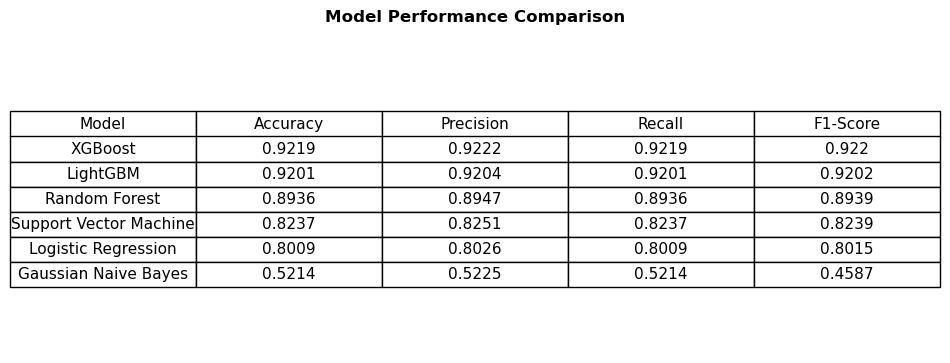

In [52]:
model_metrics = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract key metrics
    model_metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Convert to DataFrame
df_results = pd.DataFrame(model_metrics)

# Sort by Accuracy
df_results = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display Table
print("\n--- Final Model Comparison ---")
display(df_results.style.background_gradient(cmap='Blues'))

# Save as Image
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
ax.axis('tight')

# Create a visual table
table = ax.table(cellText=df_results.round(4).values, 
                 colLabels=df_results.columns, 
                 loc='center', 
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.title('Model Performance Comparison', fontweight="bold", y=1.05)
plt.savefig('../outputs/figures/model_evaluation_table.png', bbox_inches='tight', dpi=300)
print("Saved table image as model_evaluation_table.png'")
plt.show()

##### 6. Model Comparison:
• Track the performance of each model and select the best-performing model for the next steps (which will be communicated in future tasks).

In [53]:
# Comparison Table
print("\n--- Model Comparison ---")
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print(f"{'Model':<25} | {'Accuracy':<10}")
print("-" * 37)
for name, score in sorted_results:
    print(f"{name:<25} | {score:.4f}")

best_model_name = sorted_results[0][0]
print(f"\nBest Performing Model: {best_model_name}")


--- Model Comparison ---
Model                     | Accuracy  
-------------------------------------
XGBoost                   | 0.9219
LightGBM                  | 0.9201
Random Forest             | 0.8936
Support Vector Machine    | 0.8237
Logistic Regression       | 0.8009
Gaussian Naive Bayes      | 0.5214

Best Performing Model: XGBoost


In [54]:
import joblib

# Select best model
best_model = trained_models['XGBoost']

# Save the model to a file
joblib.dump(best_model, '../models/model_data.pkl')

# Save the column names
# Save the columns from X_train to match inputs later
joblib.dump(X_train.columns.tolist(), '../models/model_columns.pkl')

print("Model and columns saved successfully!")

Model and columns saved successfully!
